### Использование ончейн‑анализа для поиска перспективных проектов для инвестиций

Dune API


In [51]:
import os, time, json, requests, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (10, 5)

In [64]:
DUNE_API_KEY = os.getenv('DUNE_API_KEY')

In [53]:
BASE_URL = 'https://api.dune.com/api/v1'

def execute_query(query_id, params=None):
    """Run a saved Dune query and return execution_id"""
    url = f"{BASE_URL}/query/{query_id}/execute"
    headers = {'X-DUNE-API-KEY': DUNE_API_KEY}
    payload = {'parameters': params or {}}
    r = requests.post(url, headers=headers, json=payload, timeout=30)
    r.raise_for_status()
    return r.json()['execution_id']

def get_results(execution_id, sleep=2):
    """Poll until the execution finishes and return DataFrame"""
    url = f"{BASE_URL}/execution/{execution_id}/results"
    headers = {'X-DUNE-API-KEY': DUNE_API_KEY}
    while True:
        r = requests.get(url, headers=headers, timeout=30)
        r.raise_for_status()
        data = r.json()
        state = data['state']
        if state == 'QUERY_STATE_COMPLETED':
            df = pd.DataFrame(data['result']['rows'])
            return df
        elif state in ('QUERY_STATE_PENDING', 'QUERY_STATE_EXECUTING'):
            time.sleep(sleep)
        else:
            raise RuntimeError(f'Query failed → {state}')

In [55]:
MASS_DIST_QUERY_ID = 5005341 

exec_id = execute_query(MASS_DIST_QUERY_ID)
df_mass = get_results(exec_id)
df_mass.head()

,airdrop_number,amount_original,amount_raw,amount_usd,block_number,block_time,blockchain,contract_address,evt_index,project,recipient,token_address,token_symbol,tx_hash
0,1,3.048262,3048262458231005297,1.243266,22290690,2025-04-17 19:05:11.000 UTC,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,495,safe,0x74311284973f6e7dadf82ab4700f68f324e58165,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0xba7bcfefef507e3fb349842fd36c8d5ff22a5c098566...
1,1,26.818389,26818388534413564145,11.179991,22295677,2025-04-18 11:47:11.000 UTC,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,321,safe,0x90d3d09ebd5abce2f163f26e2606c30858d055b9,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0x472a1021d6ec761974c0b49b33885eeb5181e4505a4d...
2,1,30.501377,30501376661204246123,12.595685,22294273,2025-04-18 07:03:47.000 UTC,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,382,safe,0xd92e70aebaf48ffd74bc92da80a535e4557788b2,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0xbd1f22f1746b3ad05153482c7abbe18fe839ad9ed863...
3,1,0.799730,799729996539738713,0.322619,22287866,2025-04-17 09:37:35.000 UTC,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,325,safe,0xf5a7b7478f58efcd2c84c9c3168405e233aecfcc,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0x6f2dd7ac5dcafc9ef7345e4501d0a1fb3848011c95eb...
4,1,0.990882,990881823132737530,0.399959,22282721,2025-04-16 16:22:11.000 UTC,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,312,safe,0x5da9a1ac020163af34a614395522fb41796828f4,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0xcedfd5267de316d87b275787250d6e4312330410db2b...


In [56]:
df_mass.columns

Index(['airdrop_number', 'amount_original', 'amount_raw', 'amount_usd',
       'block_number', 'block_time', 'blockchain', 'contract_address',
       'evt_index', 'project', 'recipient', 'token_address', 'token_symbol',
       'tx_hash'],
      dtype='object')

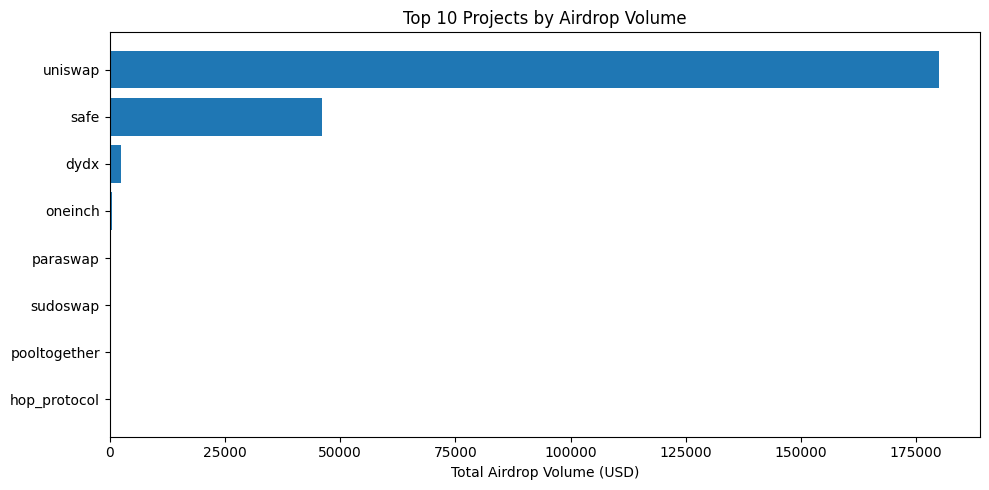

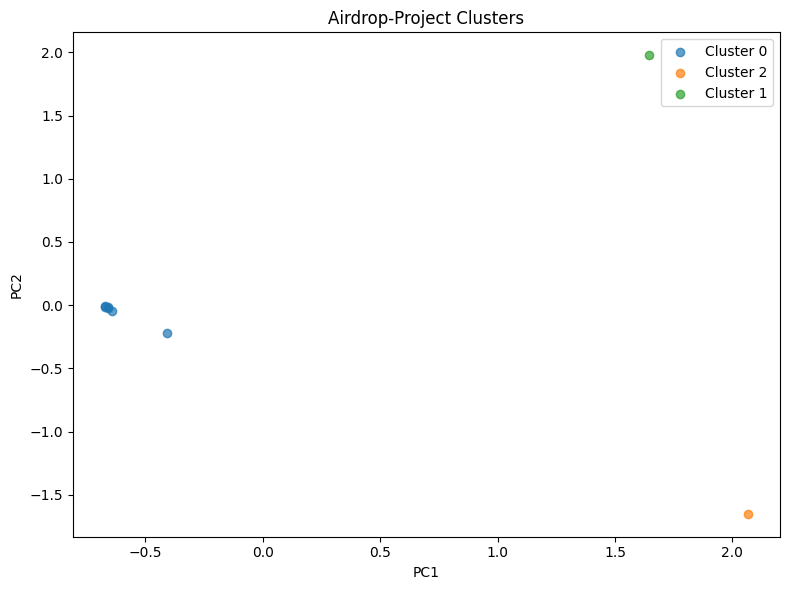

In [57]:
df_mass['block_time'] = pd.to_datetime(df_mass['block_time'])

df_mass = df_mass.drop_duplicates(subset=['tx_hash', 'recipient', 'token_address'])

agg = (
    df_mass
    .groupby('project')
    .agg(
        airdrop_count=('airdrop_number', 'nunique'),
        total_usd=('amount_usd', 'sum'),
        avg_usd=('amount_usd', 'mean'),
        unique_tokens=('token_address', 'nunique'),
        unique_recipients=('recipient', 'nunique')
    )
    .reset_index()
)

agg_top = agg.sort_values('total_usd', ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.barh(agg_top['project'], agg_top['total_usd'])
plt.xlabel('Total Airdrop Volume (USD)')
plt.title('Top 10 Projects by Airdrop Volume')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

features = agg[['total_usd', 'airdrop_count', 'unique_recipients']].fillna(0)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
agg['cluster'] = kmeans.labels_

from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X_scaled)
agg[['pc1','pc2']] = pca

plt.figure(figsize=(8,6))
for c in agg['cluster'].unique():
    sub = agg[agg['cluster']==c]
    plt.scatter(sub['pc1'], sub['pc2'], label=f'Cluster {c}', alpha=0.7)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Airdrop‑Project Clusters')
plt.tight_layout()
plt.show()

In [58]:
CLAIM_QUERY_ID = 5006414
exec_id = execute_query(CLAIM_QUERY_ID)
df_claims = get_results(exec_id)
df_claims.head()

,account,airdrop_sources,counts
0,0x8358fc2dd62c00c1a9cd0fcb577309a4cead2471,"[ENS, HOP, Uniswap, Gitcoin, 1inch]",5
1,0x8a83716acd66d9e1fb18c9b79540b72e04f80ac0,"[ENS, 1inch, Uniswap, Gitcoin, HOP]",5
2,0x958bc7f87992791e89a5cfe764ff5541f6329642,"[ENS, Uniswap, Gitcoin, 1inch, HOP]",5
3,0x1092361f4eafdc6e4555ee761e87ef9c67b9e42f,"[Uniswap, ENS, HOP, Gitcoin, 1inch]",5
4,0x6186290b28d511bff971631c916244a9fc539cfe,"[Gitcoin, Uniswap, ENS, HOP, 1inch]",5


In [59]:
df_candidates = pd.concat([
    df_mass.rename(columns={'token_address':'protocol_token'}),
    df_claims.rename(columns={'account':'protocol_token'}),
]).drop_duplicates('protocol_token')
df_candidates.head()

,airdrop_number,amount_original,amount_raw,amount_usd,block_number,block_time,blockchain,contract_address,evt_index,project,recipient,protocol_token,token_symbol,tx_hash,airdrop_sources,counts
0,1.0,3.048262,3048262458231005297,1.243266,22290690.0,2025-04-17 19:05:11+00:00,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,495.0,safe,0x74311284973f6e7dadf82ab4700f68f324e58165,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0xba7bcfefef507e3fb349842fd36c8d5ff22a5c098566...,NaN,NaN
32,1.0,23.649398,23649397640078074978,12.913257,22282042.0,2025-04-16 14:05:59+00:00,ethereum,0x92d6c1e31e14520e676a687f0a93788b716beff5,261.0,dydx,0xda24ee2c4b4b1ea69de3aa9c820438c7069d7d83,0x92d6c1e31e14520e676a687f0a93788b716beff5,DYDX,0x438a86667ae667e6612ebba1f7d47c53f157495a11b4...,NaN,NaN
33,1.0,400.000000,400000000000000000000,2080.000000,22297457.0,2025-04-18 17:44:59+00:00,ethereum,0x090d4613473dee047c3f2706764f49e0821d256e,139.0,uniswap,0xd465484af946ab1f29ffad0c6971c5fd58b7ab7d,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,UNI,0x7f59350cf0ce5a77e23c7aa7ab6d5a316fe556d4b6d3...,NaN,NaN
58,1.0,7800.000000,7800000000000000000000,NaN,22267092.0,2025-04-14 12:01:11+00:00,ethereum,0xcafe001067cdef266afb7eb5a286dcfd277f3de5,241.0,paraswap,0x090e53c44e8a9b6b1bca800e881455b921aec420,0xcafe001067cdef266afb7eb5a286dcfd277f3de5,PSP,0x921fb20af15cc100306c90381daa6865d87ecef31f80...,NaN,NaN
130,1.0,1700.610633,1700610633294716945624,8.169733,22227019.0,2025-04-08 21:58:35+00:00,ethereum,0xc5102fe9359fd9a28f877a67e36b0f050d81a3cc,625.0,hop_protocol,0x683e2ae49af295ab50d0a907077a3a612c80d592,0xc5102fe9359fd9a28f877a67e36b0f050d81a3cc,HOP,0xe62f0cdd9a64e025258fc8de7f84e61b29beef314f9f...,NaN,NaN


In [60]:
features = df_candidates[['amount_original', 'amount_raw', 'amount_usd', 'block_number', 'evt_index']].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# K‑means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
df_candidates['cluster'] = kmeans.labels_

# PCA for 2‑D visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
df_candidates[['pc1', 'pc2']] = coords
df_candidates.head()

,airdrop_number,amount_original,amount_raw,amount_usd,block_number,block_time,blockchain,contract_address,evt_index,project,recipient,protocol_token,token_symbol,tx_hash,airdrop_sources,counts,cluster,pc1,pc2
0,1.0,3.048262,3048262458231005297,1.243266,22290690.0,2025-04-17 19:05:11+00:00,ethereum,0x5afe3855358e112b5647b952709e6165e1c1eeee,495.0,safe,0x74311284973f6e7dadf82ab4700f68f324e58165,0x5afe3855358e112b5647b952709e6165e1c1eeee,SAFE,0xba7bcfefef507e3fb349842fd36c8d5ff22a5c098566...,NaN,NaN,1,73.950670,51.599938
32,1.0,23.649398,23649397640078074978,12.913257,22282042.0,2025-04-16 14:05:59+00:00,ethereum,0x92d6c1e31e14520e676a687f0a93788b716beff5,261.0,dydx,0xda24ee2c4b4b1ea69de3aa9c820438c7069d7d83,0x92d6c1e31e14520e676a687f0a93788b716beff5,DYDX,0x438a86667ae667e6612ebba1f7d47c53f157495a11b4...,NaN,NaN,1,57.958990,38.854616
33,1.0,400.000000,400000000000000000000,2080.000000,22297457.0,2025-04-18 17:44:59+00:00,ethereum,0x090d4613473dee047c3f2706764f49e0821d256e,139.0,uniswap,0xd465484af946ab1f29ffad0c6971c5fd58b7ab7d,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,UNI,0x7f59350cf0ce5a77e23c7aa7ab6d5a316fe556d4b6d3...,NaN,NaN,2,98.329392,155.286457
58,1.0,7800.000000,7800000000000000000000,NaN,22267092.0,2025-04-14 12:01:11+00:00,ethereum,0xcafe001067cdef266afb7eb5a286dcfd277f3de5,241.0,paraswap,0x090e53c44e8a9b6b1bca800e881455b921aec420,0xcafe001067cdef266afb7eb5a286dcfd277f3de5,PSP,0x921fb20af15cc100306c90381daa6865d87ecef31f80...,NaN,NaN,1,248.985450,-128.894698
130,1.0,1700.610633,1700610633294716945624,8.169733,22227019.0,2025-04-08 21:58:35+00:00,ethereum,0xc5102fe9359fd9a28f877a67e36b0f050d81a3cc,625.0,hop_protocol,0x683e2ae49af295ab50d0a907077a3a612c80d592,0xc5102fe9359fd9a28f877a67e36b0f050d81a3cc,HOP,0xe62f0cdd9a64e025258fc8de7f84e61b29beef314f9f...,NaN,NaN,1,125.330327,23.020653


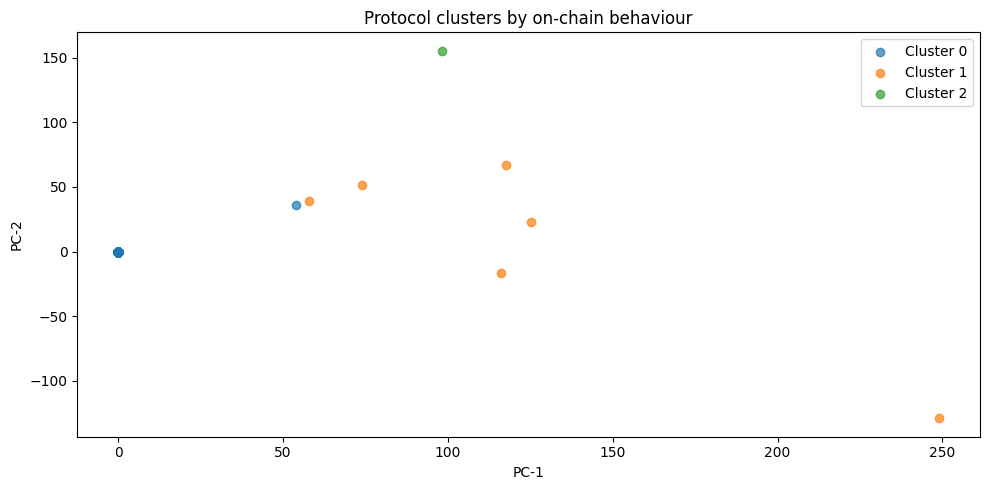

In [61]:
# Scatter plot of clusters
for label in sorted(df_candidates['cluster'].unique()):
    subset = df_candidates[df_candidates['cluster'] == label]
    plt.scatter(subset['pc1'], subset['pc2'], label=f'Cluster {label}', alpha=0.7)
plt.title('Protocol clusters by on‑chain behaviour')
plt.xlabel('PC‑1')
plt.ylabel('PC‑2')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
import numpy as np
df_model = df_candidates.copy()
df_model['did_airdrop'] = np.random.randint(0, 2, len(df_model))
X = X_scaled
y = df_model['did_airdrop']

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier().fit(X, y)
df_model['success_prob'] = clf.predict_proba(X)[:, 1]

# Risk score = inverse of success_prob for illustration
df_model['risk_score'] = 1 - df_model['success_prob']
df_model[['protocol_token', 'success_prob', 'risk_score']].head()

,protocol_token,success_prob,risk_score
0,0x5afe3855358e112b5647b952709e6165e1c1eeee,0.999978,0.000022
32,0x92d6c1e31e14520e676a687f0a93788b716beff5,0.999978,0.000022
33,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0.999978,0.000022
58,0xcafe001067cdef266afb7eb5a286dcfd277f3de5,0.000022,0.999978
130,0xc5102fe9359fd9a28f877a67e36b0f050d81a3cc,0.999978,0.000022


In [63]:
recommendations = df_model.sort_values('success_prob', ascending=False).head(10)
recommendations[['protocol_token', 'success_prob', 'risk_score']]

,protocol_token,success_prob,risk_score
0,0x5afe3855358e112b5647b952709e6165e1c1eeee,0.999978,0.000022
33,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,0.999978,0.000022
130,0xc5102fe9359fd9a28f877a67e36b0f050d81a3cc,0.999978,0.000022
403,0x111111111117dc0aa78b770fa6a738034120c302,0.999978,0.000022
748,0x0cec1a9154ff802e7934fc916ed7ca50bde6844e,0.999978,0.000022
32,0x92d6c1e31e14520e676a687f0a93788b716beff5,0.999978,0.000022
28938,0x89dfdb9680fe7e4f36f9f85d2f752a1c4053f422,0.497385,0.502615
28930,0x10c602dfa415cd81a278e0386fcfd76e1bba2b6f,0.497385,0.502615
28931,0xbd7bb0140b954427650868009d0b0b65ff7b4480,0.497385,0.502615
28932,0x8efb87fccec90b884f962ab204677640fb0f9a45,0.497385,0.502615
